In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pennylane as qml

In [3]:
# Load data
df = pd.read_csv('./dataset.csv')

# Prepare features and target
X = df.drop(columns=['COPDSEVERITY'])
y = df['COPDSEVERITY']

# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Handle missing values - fill with median for numeric columns
X = X.fillna(X.median(numeric_only=True))

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)

In [4]:
y_test

array([2, 2, 0, 2, 0, 0, 2, 1, 2, 2, 3, 2, 0, 1, 1, 2, 0, 1, 3, 2, 1])

In [5]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
X_train_scaled

array([[ 1.31667736,  0.43116841, -0.38179255, ..., -0.37796447,
        -0.5       , -0.33333333],
       [-0.85836489, -0.14436228,  0.7090433 , ..., -0.37796447,
        -0.5       , -0.33333333],
       [-0.30597321, -0.98847397, -0.51814703, ..., -0.37796447,
        -0.5       ,  3.        ],
       ...,
       [-1.27265865,  1.4095706 , -0.10908358, ..., -0.37796447,
        -0.5       , -0.33333333],
       [ 1.4202508 ,  1.42875496, -0.38179255, ..., -0.37796447,
        -0.5       , -0.33333333],
       [ 0.00474712, -0.95010526,  0.0272709 , ...,  2.64575131,
        -0.5       , -0.33333333]], shape=(80, 23))

In [7]:

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.LongTensor(y_test)


In [8]:
# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [9]:
input_dim = X_train.shape[1]
hidden1_dim = 23
n_qubits = 4  # Number of qubits for PQC
output_dim = len(np.unique(y_encoded))

In [10]:
dev = qml.device("default.qubit", wires=n_qubits)

In [11]:
@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs, weights):
    """
    Parameterized Quantum Circuit
    Args:
        inputs: classical input data (reduced dimension)
        weights: trainable quantum parameters
    """
    # Encode classical data into quantum state
    for i in range(n_qubits):
        qml.RY(inputs[i % len(inputs)], wires=i)
    
    # Parameterized quantum layers
    n_layers = weights.shape[0]
    for layer in range(n_layers):
        # Rotation gates with trainable parameters
        for i in range(n_qubits):
            qml.RY(weights[layer, i, 0], wires=i)
            qml.RZ(weights[layer, i, 1], wires=i)
        
        # Entangling gates
        for i in range(n_qubits - 1):
            qml.CNOT(wires=[i, i + 1])
        qml.CNOT(wires=[n_qubits - 1, 0])  # Circular entanglement
    
    # Measure expectations
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

In [12]:
class QuantumNeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden1_dim, n_qubits, output_dim, n_qlayers=2):
        super(QuantumNeuralNetwork, self).__init__()
        
        # Classical layers
        self.fc1 = nn.Linear(input_dim, hidden1_dim)
        self.fc2 = nn.Linear(hidden1_dim, n_qubits)  # Reduce to qubit dimension
        
        # Quantum layer parameters
        self.n_qubits = n_qubits
        self.n_qlayers = n_qlayers
        self.q_params = nn.Parameter(torch.randn(n_qlayers, n_qubits, 2) * 0.1)
        
        # Classical output layer
        self.fc3 = nn.Linear(n_qubits, output_dim)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.tanh = nn.Tanh()  # For quantum input encoding
        
    def forward(self, x):
        # Classical preprocessing
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.tanh(self.fc2(x))  # Normalize to [-1, 1] for quantum encoding
        
        # Quantum layer
        # Process each sample in the batch
        q_out_list = []
        for sample in x:
            q_out = quantum_circuit(sample, self.q_params)
            q_out_list.append(torch.stack(q_out))
        
        q_out_batch = torch.stack(q_out_list).float()
        
        # Classical output layer
        output = self.fc3(q_out_batch)
        
        return output

In [13]:
# Initialize model
model = QuantumNeuralNetwork(input_dim, hidden1_dim, n_qubits, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:

print(f'Model Architecture:')
print(f'Input Layer: {input_dim} neurons')
print(f'Hidden Layer 1 (Classical): {hidden1_dim} neurons')
print(f'Hidden Layer 2 (Quantum): {n_qubits} qubits')
print(f'Output Layer: {output_dim} neurons')
print(f'\nQuantum circuit has {model.n_qlayers} parameterized layers')
print(f'Total quantum parameters: {model.q_params.numel()}\n')

In [ ]:
num_epochs = 250  # Reduced due to quantum circuit overhead
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    if (epoch + 1) % 1 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}')

In [72]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    _, predicted = torch.max(y_pred, 1)
    acc = accuracy_score(y_test_tensor.numpy(), predicted.numpy())
    print(f'\nAccuracy: {acc:.4f}')


Accuracy: 0.9048


In [ ]:

print(f'\nModel Architecture:')
print(f'Input Layer: {input_dim} neurons')
print(f'Hidden Layer 1: {hidden1_dim} neurons')
print(f'Hidden Layer 2: {hidden2_dim} neurons')
print(f'Output Layer: {output_dim} neurons')

In [73]:

# Save the model
save_dict = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scaler': scaler,
    'label_encoder': label_encoder,
    'input_dim': input_dim,
    'hidden1_dim': hidden1_dim,
    'n_qubits': n_qubits,
    'output_dim': output_dim,
    'n_qlayers': model.n_qlayers,
    'accuracy': acc
}

torch.save(save_dict, 'quantum_copd_model.pth')
print('\nModel saved to: quantum_copd_model.pth')

# Optional: Visualize quantum circuit
print(f'\nQuantum Circuit Structure:')
print(qml.draw(quantum_circuit)(torch.randn(n_qubits), model.q_params))


Model saved to: quantum_copd_model.pth

Quantum Circuit Structure:
0: ──RY(0.57)───RY(0.70)──RZ(1.07)──╭●───────╭X──RY(-0.42)──RZ(-0.04)─╭●───────╭X─┤  <Z>
1: ──RY(1.85)───RY(0.01)──RZ(1.27)──╰X─╭●────│───RY(0.39)───RZ(-0.05)─╰X─╭●────│──┤  <Z>
2: ──RY(1.47)───RY(0.44)──RZ(-1.04)────╰X─╭●─│───RY(-0.21)──RZ(-0.15)────╰X─╭●─│──┤  <Z>
3: ──RY(-0.06)──RY(0.74)──RZ(0.84)────────╰X─╰●──RY(-0.18)──RZ(-0.05)───────╰X─╰●─┤  <Z>


In [24]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pennylane as qml

# Define the quantum circuit (same as training)
n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs, weights):
    """Parameterized Quantum Circuit"""
    for i in range(n_qubits):
        qml.RY(inputs[i % len(inputs)], wires=i)
    
    n_layers = weights.shape[0]
    for layer in range(n_layers):
        for i in range(n_qubits):
            qml.RY(weights[layer, i, 0], wires=i)
            qml.RZ(weights[layer, i, 1], wires=i)
        
        for i in range(n_qubits - 1):
            qml.CNOT(wires=[i, i + 1])
        qml.CNOT(wires=[n_qubits - 1, 0])
    
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Define the model architecture (same as training)
class QuantumNeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden1_dim, n_qubits, output_dim, n_qlayers=2):
        super(QuantumNeuralNetwork, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, hidden1_dim)
        self.fc2 = nn.Linear(hidden1_dim, n_qubits)
        
        self.n_qubits = n_qubits
        self.n_qlayers = n_qlayers
        self.q_params = nn.Parameter(torch.randn(n_qlayers, n_qubits, 2) * 0.1)
        
        self.fc3 = nn.Linear(n_qubits, output_dim)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.tanh(self.fc2(x))
        
        q_out_list = []
        for sample in x:
            q_out = quantum_circuit(sample, self.q_params)
            q_out_list.append(torch.stack(q_out))
        
        q_out_batch = torch.stack(q_out_list).float()
        output = self.fc3(q_out_batch)
        
        return output

# Load the saved model
checkpoint = torch.load('quantum_copd_model.pth',weights_only=False)

# Extract model parameters
input_dim = checkpoint['input_dim']
hidden1_dim = checkpoint['hidden1_dim']
n_qubits = checkpoint['n_qubits']
output_dim = checkpoint['output_dim']
n_qlayers = checkpoint['n_qlayers']
scaler = checkpoint['scaler']
label_encoder = checkpoint['label_encoder']

# Initialize model and load weights
model = QuantumNeuralNetwork(input_dim, hidden1_dim, n_qubits, output_dim, n_qlayers)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Load and prepare test data
df = pd.read_csv('./dataset.csv')
X = df.drop(columns=['COPDSEVERITY'])
y = df['COPDSEVERITY']

# Encode labels
y_encoded = label_encoder.fit_transform(y)

# Handle missing values
X = X.fillna(X.median(numeric_only=True))

# Split data (same as training)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)

# Scale features using the saved scaler
X_test_scaled = scaler.transform(X_test)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.LongTensor(y_test)

# Calculate loss
criterion = nn.CrossEntropyLoss()

with torch.no_grad():
    # Get predictions
    outputs = model(X_test_tensor)
    loss = criterion(outputs, y_test_tensor)
    
    # Get predicted classes
    _, y_pred = torch.max(outputs, 1)
    
    # Convert to numpy for sklearn metrics
    y_pred_np = y_pred.numpy()
    y_test_np = y_test_tensor.numpy()
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test_np, y_pred_np)
    
    # Print results
    print(f"Validation Loss: {loss.item():.4f}")
    print(f"Validation Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test_np, y_pred_np, digits=2))
    
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test_np, y_pred_np)
    print(cm)
    
    # Pretty print confusion matrix
    print("\nConfusion Matrix (formatted):")
    print("Predicted →")
    print("Actual ↓")
    header = "      " + "  ".join([f"Class {i}" for i in range(output_dim)])
    print(header)
    for i, row in enumerate(cm):
        print(f"Class {i}  " + "       ".join([f"{val:2d}" for val in row]))

Validation Loss: 0.4871
Validation Accuracy: 0.9048

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       0.82      1.00      0.90         9
           3       0.00      0.00      0.00         2

    accuracy                           0.90        21
   macro avg       0.70      0.75      0.72        21
weighted avg       0.83      0.90      0.86        21


Confusion Matrix:
[[5 0 0 0]
 [0 5 0 0]
 [0 0 9 0]
 [0 0 2 0]]

Confusion Matrix (formatted):
Predicted →
Actual ↓
      Class 0  Class 1  Class 2  Class 3
Class 0   5        0        0        0
Class 1   0        5        0        0
Class 2   0        0        9        0
Class 3   0        0        2        0


C:\Users\ASUS\miniconda3\envs\EDA\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\ASUS\miniconda3\envs\EDA\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\ASUS\miniconda3\envs\EDA\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


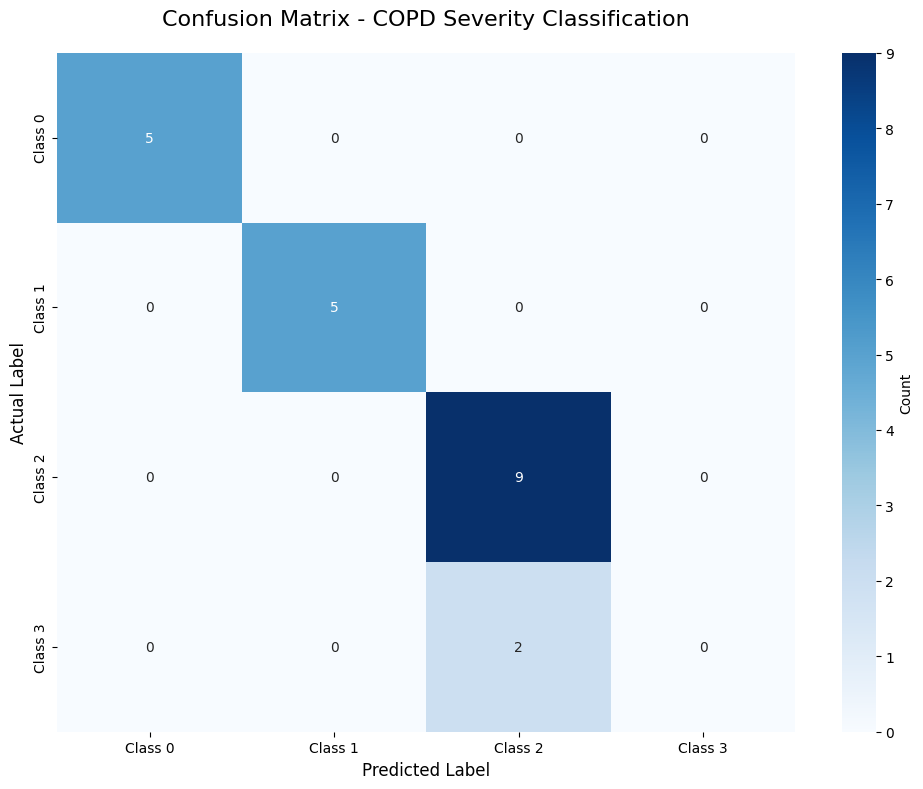

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[f'Class {i}' for i in range(output_dim)],
            yticklabels=[f'Class {i}' for i in range(output_dim)],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - COPD Severity Classification', fontsize=16, pad=20)
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()